In [1]:
!unzip -qq sentiment.zip

In [2]:
from transformers import AutoTokenizer, FlaxAutoModelForSequenceClassification
from flax.training.train_state import TrainState
import jax.numpy as jnp
import jax
import optax
from sklearn.utils import shuffle
import numpy as np

from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

NUM_LABELS = 3
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 2e-5
MODEL_NAME = 'distilbert-base-uncased'
# MODEL_NAME = "prajjwal1/bert-tiny".  # For debugging, small model

#### Utilities

In [3]:
def read_data(dir='/content/sentiment/'):
    train_df = pd.read_csv(dir + 'train.csv', encoding='ISO-8859-1')
    test_df = pd.read_csv(dir + 'test.csv', encoding='ISO-8859-1')

    label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    train_df['label'] = train_df['sentiment'].map(label_mapping)
    test_df['label'] = test_df['sentiment'].map(label_mapping)

    return train_df, test_df

def get_tokenizers(train_df, test_df, name='bert-base-uncased'):
    tokenizer = AutoTokenizer.from_pretrained(name)

    # Clean data
    train_df = train_df.dropna(subset=['text', 'label']).copy()
    test_df = test_df.dropna(subset=['text', 'label']).copy()

    # Convert to correct types
    train_df['text'] = train_df['text'].astype(str)
    test_df['text'] = test_df['text'].astype(str)
    train_df['label'] = train_df['label'].astype(int)
    test_df['label'] = test_df['label'].astype(int)

    # Extract inputs
    train_texts = train_df['text'].tolist()
    test_texts = test_df['text'].tolist()
    train_labels = train_df['label'].values
    test_labels = test_df['label'].values

    # Tokenize
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='np')
    test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors='np')

    return train_encodings, test_encodings, train_labels, test_labels, tokenizer

class TrainStateWithRNG(TrainState):
    dropout_rng: jax.random.PRNGKey

def create_train_state(apply_fn, params, learning_rate, rng=42):
    tx = optax.adamw(learning_rate)
    return TrainStateWithRNG.create(
        apply_fn=apply_fn,
        params=params,
        tx=tx,
        dropout_rng=jax.random.PRNGKey(rng)
    )

def compute_metrics(logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=NUM_LABELS)
    loss = optax.softmax_cross_entropy(logits, one_hot_labels)
    return loss.mean()

@jax.jit
def train_step(state, batch):
    rng, dropout_rng = jax.random.split(state.dropout_rng)

    def loss_fn(params):
        inputs = {k: v for k, v in batch.items() if k != 'labels'}
        logits = state.apply_fn(
            **inputs,
            params=params,
            train=True,
            dropout_rng=rng,
        )[0]
        loss = compute_metrics(logits, batch['labels'])
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, _), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    state = state.replace(dropout_rng=dropout_rng)
    return state, loss

@jax.jit
def eval_step(params, batch):
    inputs = {k: v for k, v in batch.items() if k != 'labels'}
    logits = model(**inputs, params=params, train=False)[0]
    return jnp.argmax(logits, axis=-1)

def evaluate(model, params, test_encodings, test_labels):
    preds, true = [], []
    num_batches = int(np.ceil(len(test_labels) / BATCH_SIZE))

    for i in tqdm(range(num_batches), desc="Evaluation", leave=True):
        batch = {
            'input_ids': test_encodings['input_ids'][i*BATCH_SIZE:(i+1)*BATCH_SIZE],
            'attention_mask': test_encodings['attention_mask'][i*BATCH_SIZE:(i+1)*BATCH_SIZE],
            'labels': test_labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        }

        pred = eval_step(params, batch)
        preds.extend(np.array(pred))
        true.extend(np.array(batch['labels']))

    print("\nClassification Report:")
    plot_report(true, preds)

# Report
def plot_report(y_true, y_pred):
    metrics = ['precision', 'recall', 'f1-score']
    class_names = ['negative', 'neutral', 'positive']
    report = classification_report(y_true, y_pred, labels=[0,1,2], target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    plt.figure(figsize=(8, 5))
    sns.heatmap(report_df.loc[class_names, metrics], annot=True, cmap='Blues', cbar=True)
    plt.title("Classification Report")
    plt.yticks(rotation=0)
    plt.show()

#### Run training and eval

In [4]:
train_df, test_df = read_data()
train_encodings, test_encodings, train_labels, test_labels, tokenizer = get_tokenizers(train_df, test_df, MODEL_NAME)

model = FlaxAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)  # , from_pt=True
state = create_train_state(apply_fn=model.__call__, params=model.params, learning_rate=LEARNING_RATE, rng=42)

num_batches = int(np.ceil(len(train_labels) / BATCH_SIZE))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


flax_model.msgpack:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing FlaxDistilBertForSequenceClassification: {('vocab_layer_norm', 'scale'), ('vocab_layer_norm', 'bias'), ('vocab_transform', 'kernel'), ('vocab_transform', 'bias'), ('vocab_projector', 'bias')}
- This IS expected if you are initializing FlaxDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaxDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of FlaxDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: {('classifier', 'kernel'), ('pre_classifie

In [5]:
for epoch in range(EPOCHS):
    # Shuffle data
    train_input_ids, train_attention_mask, train_labels_shuffled = shuffle(
        train_encodings['input_ids'], train_encodings['attention_mask'], train_labels
    )

    for i in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True):
        batch = {
            'input_ids': train_input_ids[i*BATCH_SIZE:(i+1)*BATCH_SIZE],
            'attention_mask': train_attention_mask[i*BATCH_SIZE:(i+1)*BATCH_SIZE],
            'labels': train_labels_shuffled[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        }
        state, loss = train_step(state, batch)

        if (i+1) % 100 == 0:
            tqdm.write(f"Epoch {epoch+1}/{EPOCHS} | Batch {i+1}/{num_batches} | Loss: {loss.item()}")

Epoch 1/10:   0%|          | 0/430 [00:00<?, ?it/s]

Epoch 1/10 | Batch 100/430 | Loss: 0.42852815985679626
Epoch 1/10 | Batch 200/430 | Loss: 0.6237784624099731
Epoch 1/10 | Batch 300/430 | Loss: 0.5682582259178162
Epoch 1/10 | Batch 400/430 | Loss: 0.43093615770339966


Epoch 2/10:   0%|          | 0/430 [00:00<?, ?it/s]

Epoch 2/10 | Batch 100/430 | Loss: 0.5046373605728149
Epoch 2/10 | Batch 200/430 | Loss: 0.4092344045639038
Epoch 2/10 | Batch 300/430 | Loss: 0.6394945979118347
Epoch 2/10 | Batch 400/430 | Loss: 0.47985491156578064


Epoch 3/10:   0%|          | 0/430 [00:00<?, ?it/s]

Epoch 3/10 | Batch 100/430 | Loss: 0.26163044571876526
Epoch 3/10 | Batch 200/430 | Loss: 0.39703279733657837
Epoch 3/10 | Batch 300/430 | Loss: 0.28760024905204773
Epoch 3/10 | Batch 400/430 | Loss: 0.3082500100135803


Epoch 4/10:   0%|          | 0/430 [00:00<?, ?it/s]

Epoch 4/10 | Batch 100/430 | Loss: 0.2511553168296814
Epoch 4/10 | Batch 200/430 | Loss: 0.2973070442676544
Epoch 4/10 | Batch 300/430 | Loss: 0.18529975414276123
Epoch 4/10 | Batch 400/430 | Loss: 0.2214549332857132


Epoch 5/10:   0%|          | 0/430 [00:00<?, ?it/s]

Epoch 5/10 | Batch 100/430 | Loss: 0.23960572481155396
Epoch 5/10 | Batch 200/430 | Loss: 0.19790586829185486
Epoch 5/10 | Batch 300/430 | Loss: 0.14331957697868347
Epoch 5/10 | Batch 400/430 | Loss: 0.2954387068748474


Epoch 6/10:   0%|          | 0/430 [00:00<?, ?it/s]

Epoch 6/10 | Batch 100/430 | Loss: 0.19782905280590057
Epoch 6/10 | Batch 200/430 | Loss: 0.25361114740371704
Epoch 6/10 | Batch 300/430 | Loss: 0.07712456583976746
Epoch 6/10 | Batch 400/430 | Loss: 0.08954169601202011


Epoch 7/10:   0%|          | 0/430 [00:00<?, ?it/s]

Epoch 7/10 | Batch 100/430 | Loss: 0.1809711754322052
Epoch 7/10 | Batch 200/430 | Loss: 0.07417434453964233
Epoch 7/10 | Batch 300/430 | Loss: 0.17810289561748505
Epoch 7/10 | Batch 400/430 | Loss: 0.16081202030181885


Epoch 8/10:   0%|          | 0/430 [00:00<?, ?it/s]

Epoch 8/10 | Batch 100/430 | Loss: 0.09149891138076782
Epoch 8/10 | Batch 200/430 | Loss: 0.05459729954600334
Epoch 8/10 | Batch 300/430 | Loss: 0.024436375126242638
Epoch 8/10 | Batch 400/430 | Loss: 0.02122112736105919


Epoch 9/10:   0%|          | 0/430 [00:00<?, ?it/s]

Epoch 9/10 | Batch 100/430 | Loss: 0.07239069044589996
Epoch 9/10 | Batch 200/430 | Loss: 0.015027107670903206
Epoch 9/10 | Batch 300/430 | Loss: 0.14414606988430023
Epoch 9/10 | Batch 400/430 | Loss: 0.08981377631425858


Epoch 10/10:   0%|          | 0/430 [00:00<?, ?it/s]

Epoch 10/10 | Batch 100/430 | Loss: 0.028997235000133514
Epoch 10/10 | Batch 200/430 | Loss: 0.09892947226762772
Epoch 10/10 | Batch 300/430 | Loss: 0.09854184836149216
Epoch 10/10 | Batch 400/430 | Loss: 0.0790829136967659


Evaluation:   0%|          | 0/56 [00:00<?, ?it/s]


Classification Report:


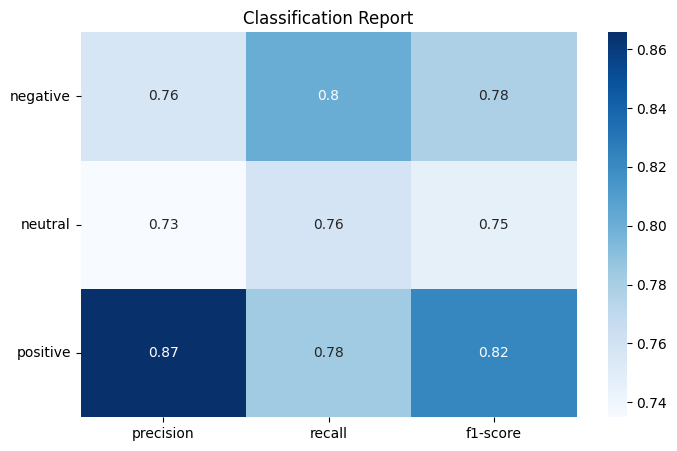

In [6]:
evaluate(model, state.params, test_encodings, test_labels)